## Test cluster analysis of travel sample data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
data = pd.read_csv('fareportal_test/data.csv')

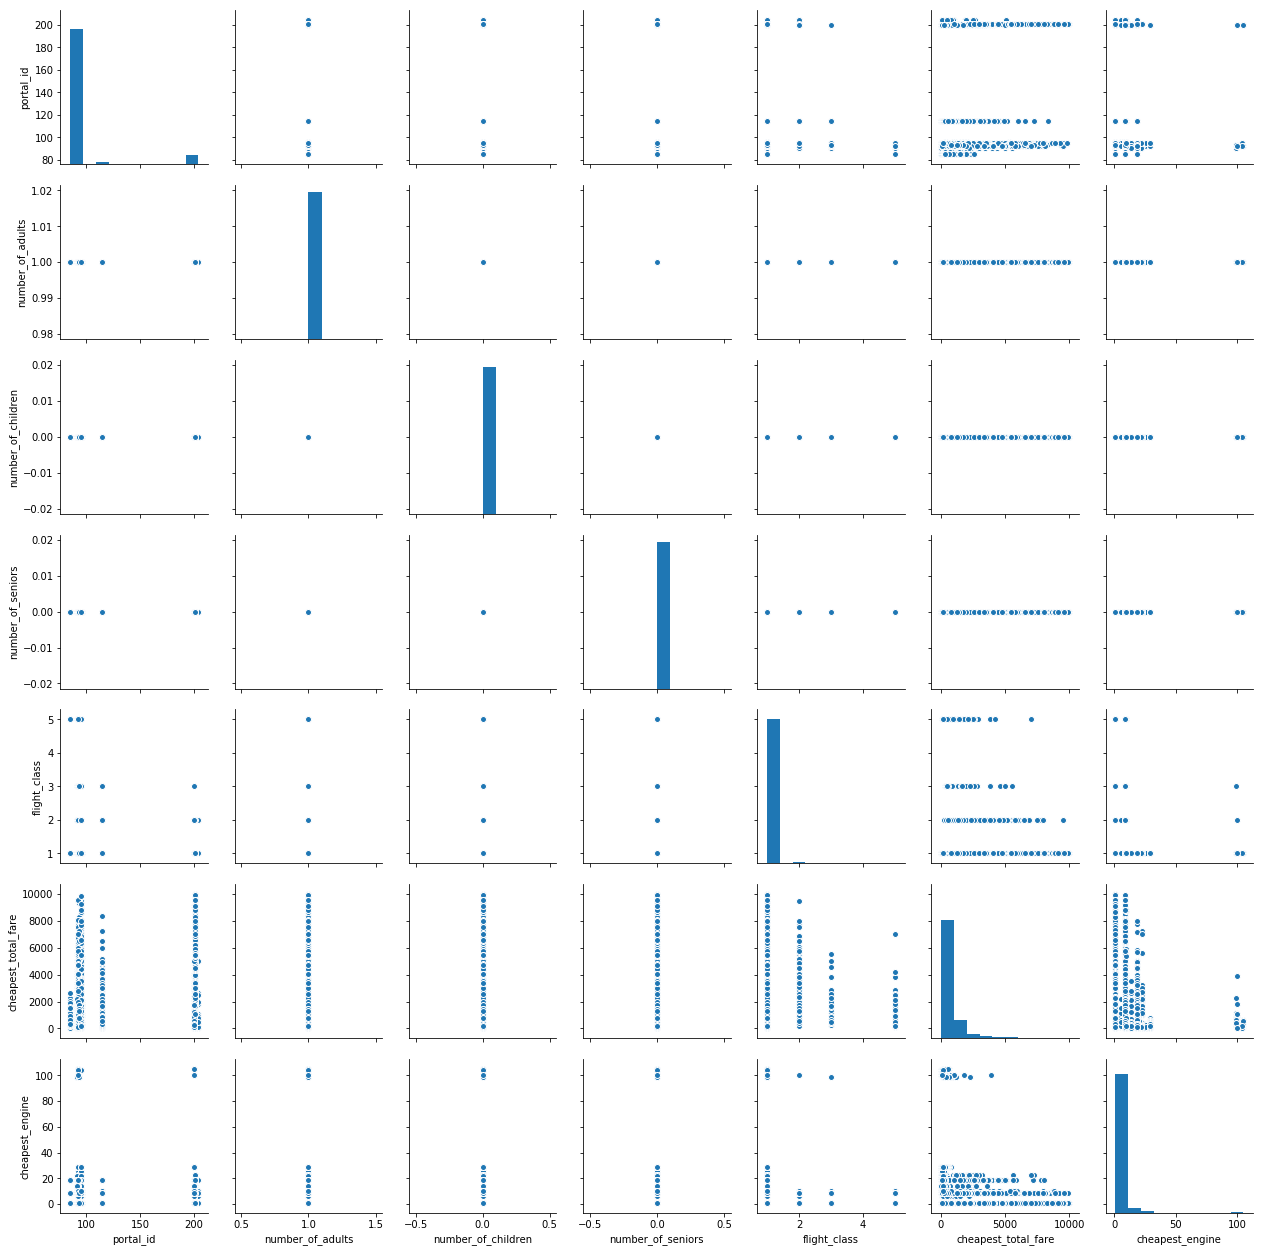

In [6]:
import seaborn as sns
sns.pairplot(data)

** As long as 'number_of_adults', 'number_of_children', 'number_of_seniors' has constant value,<br/> **

**Take it's to account and drop uninformative columns from data **

In [7]:
data.drop(['number_of_adults', 'number_of_children','number_of_seniors'], axis=1, inplace=True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25200 entries, 0 to 25199
Data columns (total 13 columns):
portal_id              25200 non-null int64
searched_date          25200 non-null object
origin                 25200 non-null object
destination            25200 non-null object
departure_date         25200 non-null object
return_date            15019 non-null object
flight_class           25200 non-null int64
cheapest_total_fare    25200 non-null float64
cheapest_engine        25200 non-null int64
unique_airlines        25200 non-null object
country_code           25198 non-null object
region                 25200 non-null object
city                   25200 non-null object
dtypes: float64(1), int64(3), object(9)
memory usage: 2.5+ MB


**Got some initial information.** <br/>

**E.g. portal_id and cheapest_engine are numerical, but their meaning is categorical by nature.**

**In order to perform Exploratory data analysis, use import pandas_profiling **

In [9]:
import pandas_profiling
pandas_profiling.ProfileReport(data) 

Number of variables,13
Number of observations,25200
Total Missing (%),3.1%
Total size in memory,2.5 MiB
Average record size in memory,104.0 B
Numeric,4
Categorical,9
Boolean,0
Date,0
Text (Unique),0
Rejected,0


**got next information: ** <br/>
    Searches relate to first 14 days of the 2017 year, each day consists of 1800 lines.<br/>
    
Among 4 numerical columns, only 2 could be used for clustering: <br/>
**cheapest_total_fare** : a good column for analysis <br/>
**flight_class** : 98,3% of searches belong to the first class, strange value also occurs "5"
        
Among 9 categorical columns got more information, **"origin"** and **"destination"** require attention. <br/>
"return day" has a lot of missing values.
    
Clustering task is solved separately for numerical and for categorical values.<br/>
For numerical values let's add some columns: <br/>
**time_to_trip** as the difference between departure day as search day,<br/>
**number_unique_airlines** as number of possible ways to get to the point <br/>
**search_day** as ordered day of search 

In [12]:
data['departure_date']=pd.to_datetime(data['departure_date'])
data['searched_date']=pd.to_datetime(data['searched_date'])
data['time_to_trip']=data['departure_date']-data['searched_date']
data['time_to_trip'] = data['time_to_trip'].dt.days

In [13]:
data['number_unique_airlines'] = data.unique_airlines.str.split().apply(len)
data['search_day'] = data['searched_date'].dt.day

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25200 entries, 0 to 25199
Data columns (total 16 columns):
portal_id                 25200 non-null int64
searched_date             25200 non-null datetime64[ns]
origin                    25200 non-null object
destination               25200 non-null object
departure_date            25200 non-null datetime64[ns]
return_date               15019 non-null object
flight_class              25200 non-null int64
cheapest_total_fare       25200 non-null float64
cheapest_engine           25200 non-null int64
unique_airlines           25200 non-null object
country_code              25198 non-null object
region                    25200 non-null object
city                      25200 non-null object
time_to_trip              25200 non-null int64
number_unique_airlines    25200 non-null int64
search_day                25200 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(6), object(7)
memory usage: 3.1+ MB


** As long as numerical algorithms require numerical columns, let's select them separately** <br/>

In [15]:
numcolumns=['cheapest_total_fare','flight_class','time_to_trip','number_unique_airlines']
datanumerical = data.loc[:,numcolumns]

In [16]:
datanumerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25200 entries, 0 to 25199
Data columns (total 4 columns):
cheapest_total_fare       25200 non-null float64
flight_class              25200 non-null int64
time_to_trip              25200 non-null int64
number_unique_airlines    25200 non-null int64
dtypes: float64(1), int64(3)
memory usage: 787.6 KB


** For clustering algorithm, we could use Knn method. <br/>
In order to select parameter we could inspect inertia decrease with various amounts of parameter.<br/>
In order to scale data let's use scaler first. **

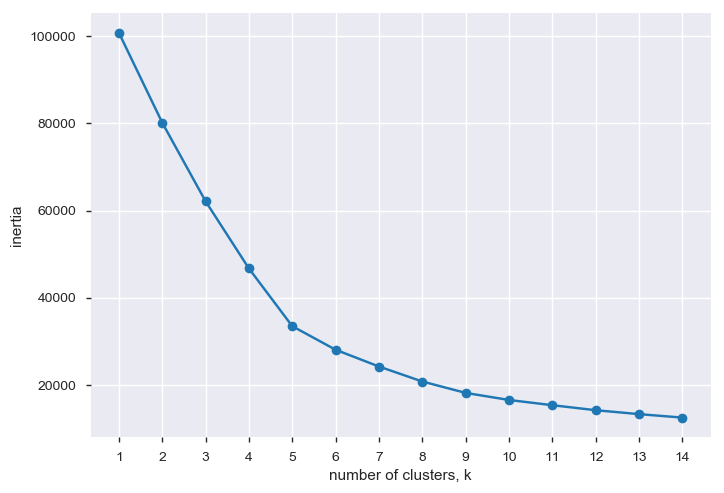

In [17]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(datanumerical)
datasci_trans = scaler.transform(datanumerical)
ks = range(1, 15)
inertias = []


for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(datasci_trans)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

**Substantial decrease of inertia takes place between 4 and 7 number of clusters. <br/>
In order to get additional support in a number of clusters selection, let's try TSNE for visualization of data in 2D. **

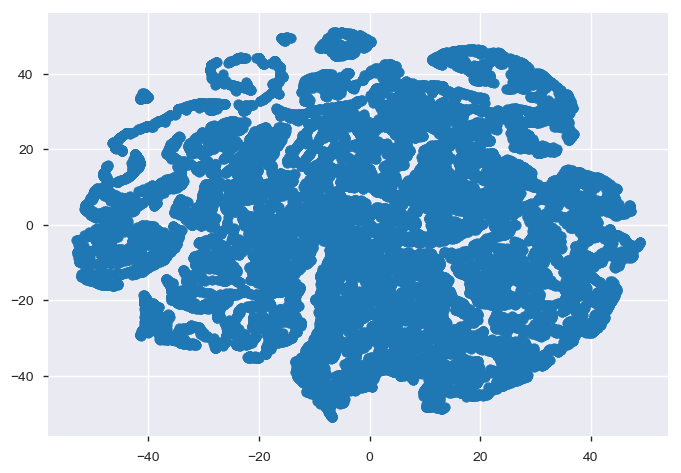

In [18]:
from sklearn.manifold import TSNE
model = TSNE(learning_rate = 50)
transformed = model.fit_transform(datasci_trans)
# Select the 0st feature: xs
xs = transformed[:,0]

# Select the 1st feature: ys
ys = transformed[:,1]
plt.scatter(xs,ys)
plt.show()

**This plot doesn't provide hint's an exact number of clusters.<br/> **

**I select to choose 6 clusters rather from previous plot.**

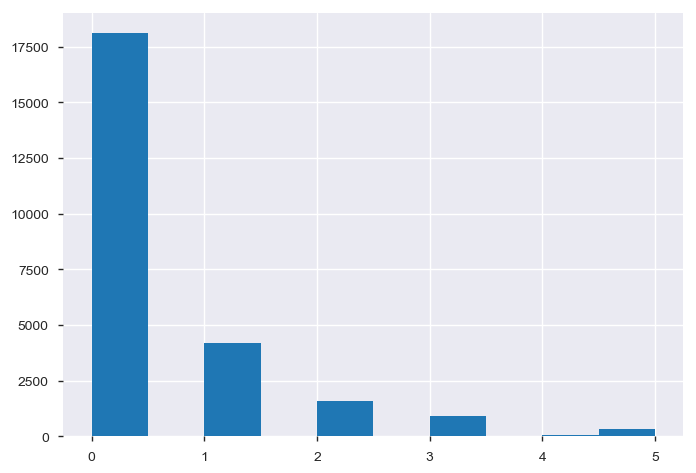

In [28]:
scaler = StandardScaler()
scaler.fit(datanumerical)
datasci_trans = scaler.transform(datanumerical)
model = KMeans(n_clusters=6)

model.fit(datasci_trans)
data['Kmean6'] = model.labels_
data['Kmean6'].hist()


**Let's use PCA for further data analysis **

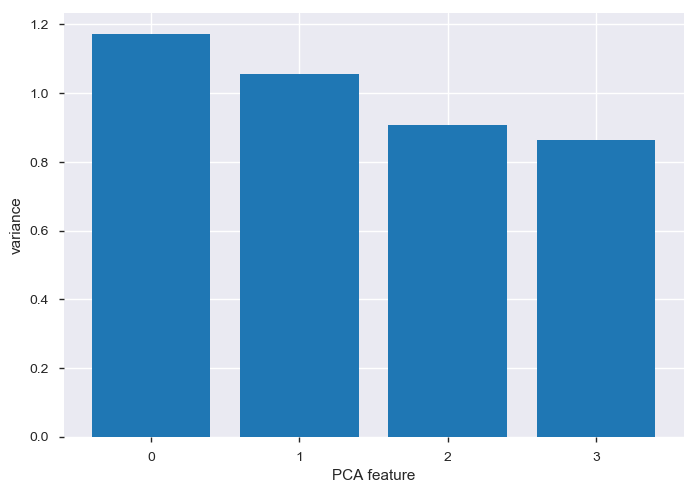

In [29]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, pca)

# Fit the pipeline to data
pipeline.fit(datanumerical)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

**PCA doesn't provide significant improvement of variance**

**For categorical variables we could use the k-mode method:**

In [36]:
from kmodes.kmodes import KModes

data['portal_id']=pd.Categorical(data['portal_id'])
data['cheapest_total_fare']=pd.Categorical(data['cheapest_total_fare'])

categorical_vars = ['origin','destination', 'portal_id', 'cheapest_total_fare']
data_categotical = data.loc[:,categorical_vars]
km = KModes(n_clusters=6, init='Huang', n_init=20, verbose=1)

data['clusters_categorical'] = km.fit_predict(data_categotical)


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 358, cost: 77718.0
Run 1, iteration: 2/100, moves: 0, cost: 77718.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 58, cost: 79831.0
Run 2, iteration: 2/100, moves: 0, cost: 79831.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 2482, cost: 76492.0
Run 3, iteration: 2/100, moves: 22, cost: 76492.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 374, cost: 76424.0
Run 4, iteration: 2/100, moves: 0, cost: 76424.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 2219, cost: 77589.0
Run 5, iteration: 2/100, moves: 1, cost: 77589.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 

In [37]:
pd.crosstab(data['clusters_categorical'], data['Kmean6'])

Kmean6,0,1,2,3,4,5
clusters_categorical,,,,,,
0,8693,1698,915,575,27,107
1,6932,1794,562,219,32,222
2,26,19,8,4,0,3
3,851,180,0,11,0,5
4,1512,444,59,103,4,14
5,102,43,28,6,1,1


**Crosstab shows different data distribution among 2 types of clustering.**

<br/> In both cases cluster "0" and "1" are largest. Crosstab allows us to get less amount of this clusters. <br/>
Cluster "4" categorical and "0" Kmean significant in amount and distinctive. <br/>

**Depending on the aim of clustering little elements could be grouped together and further analysis could be provided: <br/>
how clustering relates to days of search, to the labeled country, to search engine and other.**

**So results of clustering of separate numerical and categorical columns differ.**

**Further improvements:**<br/>
1. Use of external data for origin and destination fields. I have found on git-hub info with a link to airport type, city name,  country, GPS address and joined. Unfortunately, not all codes were in the required file. In case of join, we could make clustering based on country, internal travel or international, type of airport. Also, I could try to finetune models with varying parameters. <br/>
2. Use of geographical Pylibs with displaying the path of travel. <br/>
3. Use of categorical columns with missings. <br/>
4. Use mixing of various clustering results in order to get new clusterization.